## > Import libraries

In [5]:
## Install and Import packages
#!git clone https://github.com/CSchoel/nolds.git
!pip install nolds
import sys
import time
import nolds
import numpy as np
import pandas as pd
from scipy.io import loadmat
from tabulate import tabulate
from sklearn import preprocessing
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

In [2]:
## Mounting Google Drive2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## > Functions

In [3]:
## Import data
# scene = 'Indian_Pines' / 'PaviaU',
# type = 'Supervised' / 'unSupervised',
# n = '18' .. to ..  '25'
def load_data(scene = 'Indian_Pines'):
  
    img_file = '/content/drive/My Drive/Major_Project/Data/' + scene + '.mat'
    img_gt_file = '/content/drive/My Drive/Major_Project/Data/' + scene + '_gt.mat'

    img = loadmat(img_file)
    gt = loadmat(img_gt_file)

    if scene == 'PaviaU':
        img = img['paviaU']
        gt = gt['paviaU_gt']
    elif scene == 'Indian_Pines':
        img = img['indian_pines_corrected']
        gt = gt['indian_pines_gt']
    else:
        print("scene does not exist")

    height, width, bands = img.shape[0], img.shape[1], img.shape[2]
    num_classes = len(np.unique(gt))
    background = gt[gt == 0]
    print(img.shape)

    s1 = plt.figure()
    ax = plt.Axes(s1, [0., 0., 1., 1.])
    ax.set_axis_off()
    s1.add_axes(ax)
    plt.imshow(img[:,:,50], cmap='gray')
    plt.savefig('PU.png', dpi=300)

    #reshaping image to vector
    img = np.reshape(img, [height*width, bands])
    img_orig = img
    img_gt = np.reshape(gt, [height*width,])
    img = preprocessing.normalize(img.astype('float32'))
    
    #sanity checks
    print("Number of Label Classes: ", num_classes)
    print("Image size: ", img.shape)
    print("Label size: ", img_gt.shape)
    print("Background Pixels: ", background.shape)
    print("\n Class distribution: => ")
    print(tabulate(np.unique(img_gt, return_counts=True), tablefmt="grid"))

    s2 = plt.figure()
    ax = plt.Axes(s2, [0., 0., 1., 1.])
    ax.set_axis_off()
    s2.add_axes(ax)
    plt.imshow(gt, cmap = 'jet')
    plt.savefig('PU_gt.png', dpi=300)

    plt.figure()
    plt.plot(img[1,])

    return img_orig, img, img_gt, num_classes

In [4]:
def classList(img_gt, num_classes):

    #store indices of each class in a list of lists (ignoring the background class label 0)
    class_dist = [] 
    for i in range(1, num_classes):
        #fetch indices corresponding to class i 
        class_index = np.nonzero(img_gt == i)[0].tolist()
        #append the obtained list as an item to the main list 
        class_dist.append(class_index) 

    return class_dist

In [6]:

def evaluate_Algo(img, img_gt, class_dist, num_classes):

    bands = img.shape[1]
    #Initialize info storing table
    table = [] 
    #array for the sequential FD plot - FD vs #attributes considered
    FD_plot = []
    #Initialize diff storing 2-D array - initialize difference storage var to 1 as to act as +inf for change in FD
    diff = np.arange(bands*bands*num_classes*1.0).reshape((bands, bands, num_classes))*0 + 1 
    #store matrix- x[i,j] denote the fractal dimension in the i'th iteration after removing the j'th band in x(updated one)
    x1_matrix = np.arange(bands*bands*1.0).reshape((bands, bands))*0 + 1 
    #setting optimal dimension as 5. We will inspect the plot obtained and then come here again to change the value.
    opt_dim = 5

    #picking the first pixel from each  class and fetch in img
    idx_list = [class_dist[i][0] for i in range(len(class_dist))]
    x_all = img[idx_list,:]
    #should be equal to [num_classes-1 x bands]
    print("X_all shape: ", x_all.shape)

    #iterating for each class
    for k in range(len(class_dist)):
        x = x_all[k,:]

        #Iterating after removal of one band with min Fractal change
        for i in range(bands-opt_dim):

            #Iterating to find band with min Fractal change
            for j in range(bands-i):
              
                #find FD
                start_time = time.time()
                h = nolds.corr_dim(x, 1) 
                dur = (time.time() - start_time)
                print("Duration is: ", dur)
                #deleting a band
                x1 = np.delete(x, j)
                #sanity check
                #print("X shape: ", x.shape, " X1 shape: ", x1.shape)
                #find partial FD
                h1 = nolds.corr_dim(x1, 1)
                #find absolute difference between FD and partial FD 
                diff[i,j,k] = abs(h1-h) 
                #store the fractal dimension after removal of that band 
                x1_matrix[i,j] = h1

            #compute index of min difference in FD and partial FD  
            min_index_col = np.argmin(diff[i,:,k], axis=0) 
            #Store details in info table
            table.append([k, i, diff[i,min_index_col,k], min_index_col, x.shape, x1_matrix[i,min_index_col]])
            #store FD values of min difference column
            FD_plot.append(x1_matrix[i, min_index_col])
            #sanity checks
            print(x.shape)
            print(min_index_col)
            #reset x after deleting band causing min change in FD or having highest correlation
            x = np.delete(x, min_index_col)

        #print table defining table headers
        table.append([" ", " ", " ", " ", " ", " "])
        headers = ["Class", "Iteration", "Minimum fractal Diff", "Band with Min Diff", "New Shape", "New X1"]
        print(tabulate(table, headers, tablefmt="github"))
        print('**************************** \n ********************************** \n ***********************************')

    #save the info table in a CSV file
    df = pd.DataFrame(table, columns= headers)
    full_path = '/content/drive/My Drive/Major_Project/Supervised_Results/' + scene + '/Info/FD1_Algo.csv'
    df.to_csv(full_path, index = False, header=True)

    return diff

In [ ]:
def plot_diffFD(diff, class_dist):

    classes = len(class_dist)
    bands = diff.shape[0]

    #plot the difference as function of removed bands
    for i in range(classes):

        #make an array of the min differences (change in FD) 
        min_fd = np.min(diff[:,:,i], axis=1)
        
        #plot figure
        fig = plt.figure()
        plt.plot(min_fd[:(bands-7)])
        plt.title('Class ' + str(i))
        fig.suptitle('Fractal Dimension Difference vs Bands Removed')
        plt.xlabel('ith iteration (i bands removed)')
        plt.ylabel('Difference in FD')
        plt.show()
        #save the result
        full_path = '/content/drive/My Drive/Major_Project/Supervised_Results/' + scene + '/Info/diffFD1_Class_' + str(i) + '.jpg'
        fig.savefig(full_path, dpi=300)

In [ ]:
def plot_smoothFD(diff, class_dist):

    classes = len(class_dist)
    bands = diff.shape[0]

    for i in range(classes):

        #make an array of the min differences (change in FD) 
        min_fd = np.min(diff[:,:,i], axis=1)

        #smooth the fractal plot over a zoomed window frame
        y = savgol_filter(min_fd[(bands-40):(bands-7)], 9,3)

        #display the smoothed plot and save the results
        fig = plt.figure()
        plt.plot(y)
        plt.show()
        full_path = '/content/drive/My Drive/Major_Project/Supervised_Results/' + scene + '/Info/smoothFD1_Class_' + str(i) + '.jpg'
        fig.savefig(full_path, dpi=300)

In [ ]:
def get_Reduced(img, class_dist, opt_dim):

    img_f = img
    bands = img.shape[1]
    #Initialize diff storing 2-D array - initialize difference storage var to 1 as to act as +inf for change in FD
    diff = np.arange(bands*bands*1.0).reshape((bands, bands))*0 + 1 
    #vector for reduced dimension
    img_f_dr = np.arange(img_f.shape[0]*opt_dim*1.0).reshape((img_f.shape[0], opt_dim))*0
    #vector for reduced original dimension
    img_orig_dr = np.arange(img_f.shape[0]*opt_dim*1.0).reshape((img_f.shape[0], opt_dim))*0
    #sample x array
    x_f_dr = np.arange(len(class_dist)*opt_dim*1.0).reshape((len(class_dist), opt_dim))*0

    for k in range(len(class_dist)):

        x = img_f[class_dist[k][0],:]
        x_class = img_f[class_dist[k],:]
        x_orig_class = img_orig[class_dist[k],:]

        #sanity checks
        print("Class: ", k)
        print("\n X shape: ", x.shape, " x_class shape: ", x_class.shape)
        
        #Iterating after removal of one band with min Fractal change
        for i in range(bands-opt_dim):

            #Iterating to find band with min Fractal change
            for j in range(bands-i):

                #find FD
                h = nolds.corr_dim(x, 1) 
                #deleting a band
                x1 = np.delete(x, j)
                #sanity check
                # print("X shape: ", x.shape, " X1 shape: ", x1.shape)
                #find partial FD
                h1 = nolds.corr_dim(x1, 1)
                #find absolute difference between FD and partial FD 
                diff[i,j] = abs(h1-h)

            #compute index of min difference in FD and partial FD  
            min_index_col = np.argmin(diff[i,], axis=0) 

            #reset x after deleting band causing min change in FD or having highest correlation
            x = np.delete(x, min_index_col)
            x_class = np.delete(x_class, min_index_col, axis = 1)
            x_orig_class = np.delete(x_orig_class, min_index_col, axis = 1)

            #sanity check
            print("X shape: ", x.shape, "X_class shape: ", x_class.shape, " Minimum index: ", min_index_col)

        #set the reduced x at the position
        x_f_dr[k,:] = x
        img_f_dr[class_dist[k],:] = x_class
        img_orig_dr[class_dist[k],:] = x_orig_class
        print("\n ------------------------------------------------------------- \n")

    #save the reduced x file
    print(x_f_dr.shape)
    print(img_f_dr.shape)
    print(img_orig_dr.shape)

    full_path = '/content/drive/My Drive/Major_Project/Supervised_Results/' + scene + '/DR/img_f_DR_' + str(opt_dim) + '.npy'
    np.save(full_path, img_f_dr)

    full_path = '/content/drive/My Drive/Major_Project/Supervised_Results/' + scene + '/DR/img_orig_DR_' + str(opt_dim) + '.npy'
    np.save(full_path, img_f_dr)

    full_path = '/content/drive/My Drive/Major_Project/Supervised_Results/' + scene + '/DR/x_f_DR' + str(opt_dim) + '.npy'
    np.save(full_path, x_f_dr)

## > Main - Classwise Pixel

(145, 145, 200)
Number of Label Classes:  17
Image size:  (21025, 200)
Label size:  (21025,)
Background Pixels:  (10776,)

 Class distribution: => 
+-------+----+------+-----+-----+-----+-----+----+-----+----+-----+------+-----+-----+------+-----+----+
|     0 |  1 |    2 |   3 |   4 |   5 |   6 |  7 |   8 |  9 |  10 |   11 |  12 |  13 |   14 |  15 | 16 |
+-------+----+------+-----+-----+-----+-----+----+-----+----+-----+------+-----+-----+------+-----+----+
| 10776 | 46 | 1428 | 830 | 237 | 483 | 730 | 28 | 478 | 20 | 972 | 2455 | 593 | 205 | 1265 | 386 | 93 |
+-------+----+------+-----+-----+-----+-----+----+-----+----+-----+------+-----+-----+------+-----+----+
X_all shape:  (16, 200)
Duration is:  0.17755699157714844
Duration is:  0.0069048404693603516
Duration is:  0.010948657989501953
Duration is:  0.006914615631103516
Duration is:  0.006973743438720703
Duration is:  0.007110118865966797
Duration is:  0.0075414180755615234
Duration is:  0.0075168609619140625
Duration is:  0.00681

KeyboardInterrupt: ignored

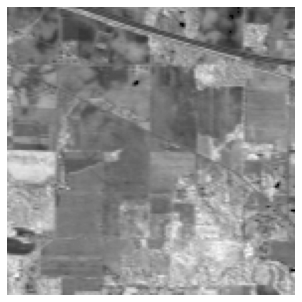

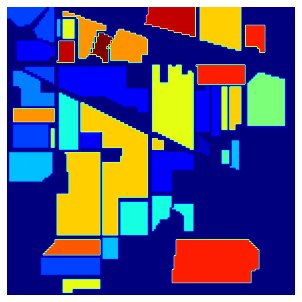

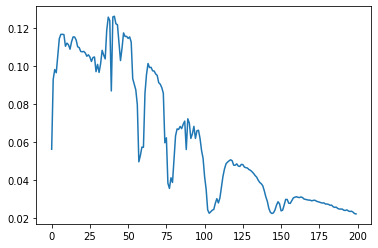

In [7]:
# define 
scene = 'Indian_Pines'

# # Load data
img_orig, img, img_gt, num_classes = load_data(scene = scene)

# Class List 
class_dist = classList(img_gt, num_classes)

# # # Evaluate Algorithm
# # orig_stdout = sys.stdout
# # output_path = '/content/drive/My Drive/Major_Project/Supervised_Results/' + scene + '/Info/Log_Algo.txt'
# # f = open(output_path, 'w')
# # sys.stdout = f

diff = evaluate_Algo(img, img_gt, class_dist, num_classes)

# plot_diffFD(diff, class_dist)

# plot_smoothFD(diff, class_dist)

# for i in range(15,28):
#     get_Reduced(img, class_dist, i)
#     print("Completed Iteration : ", i)

# sys.stdout = orig_stdout
# f.close()

## > Points

* Take average of all classes
* Show that by inspection, we can say that it is nearly 17 for most of the classes.
* Say that it is entirely possible that different classes or different kind of pixels can indeed lead to a different optimal dimension.
* And hence, the variance in elbow position is justified.
* When sticking to this method, 
* We can take some embedding delay and embed dimension according to intuition. 
* Check if including embeding dimension helps in a better classification.
